## SVD-DLinear
Official implementation of the hybrid SVD-DLinear model. 

[Hetherington, Ashton, Javier López Leonés, and Soledad Le Clainche. "LC-SVD-DLinear: A low-cost physics-based hybrid machine learning model for data forecasting using sparse measurements." arXiv preprint arXiv:2411.17433 (2024)](https://arxiv.org/abs/2411.17433)

**Description**

SVD-DLinear and HOSVD-DLinear are hybrid physics-informed neural networks designed for forecasting fluid dynamics datasets. Contrary to LC-SVD-DLinear and LC-HOSVD-DLinear, these models use high-resolution data directly.

In [1]:
# Install libraries
!pip install -q optuna torch termcolor

In [2]:
### Imports
import numpy as np
from termcolor import colored
import pickle
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import pearsonr 
from scipy.fftpack import fft

import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

%matplotlib inline

# Configure the plot appearance
plt.rc('axes', labelsize = 18)
plt.rc('axes', titlesize = 18)
plt.rc('legend', fontsize = 22)
plt.rc('figure', titlesize = 24)
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16)

### Use cases
You can run this notebook two different ways:
1. Train the model from scratch. In this case, run the entire notebook.
2. Use the pretrained model for the test case to generate predictions. Skip to the **Using a pretrained model** section, or cell `[58]`.

### Callbacks

In [3]:
### Early stopping callback
class EarlyStopping():
  '''
  Callback used to avoid model overfitting during training. If the validation
  loss does not improve during a number of epochs, the model will stop training.
  Args:
      - patience: number of epochs evaluated after validation loss plateau, before stopping training
      - model_save_path: name of the file where the model parameters are saved
      - min_delta: minumum variation of validation loss between iterations
          val_loss[n] - val_loss[n - 1] <= min_delta
  '''
  def __init__(self, patience, model_save_path, min_delta = 0):
      self.patience = patience
      self.min_delta = min_delta
      self.model_save_path = model_save_path
      self.counter = 0
      self.min_validation_loss = np.inf
      self.best_epoch = 0
      self.early_stop = False

  def __call__(self, epoch, model, validation_loss):
      delta_loss = self.min_validation_loss - validation_loss
      if delta_loss > self.min_delta:
          self.min_validation_loss = validation_loss
          self.counter = 0
          self.best_epoch = epoch
          torch.save(model.state_dict(), self.model_save_path)
      else:
          self.counter += 1
          if self.counter >= self.patience:
              print('Early stopping')
              print(f'Saved best model at epoch {self.best_epoch}')
              self.early_stop = True

# Reduce LR on plateau
class LRScheduler():
  '''
  Reduce optimizer learning rate when the model validation loss does not improve
  Args:
      - optimizer: optimizer used during training (SGD, Adam, Adam, etc.)
      - patience: number of epochs evaluated after a possible learning rate plateau before applying a decrease
      - min_lr: minimum learning rate value. Default is 1e-06
      - factor: value by which the learning rate is reduced. Default is 0.5
  '''
  def __init__(self, lr, optimizer, patience, min_lr = 1e-6, factor = 0.5):
      self.optimizer = optimizer
      self.patience = patience
      self.min_lr = min_lr
      self.prev_lr = lr
      self.factor = factor
      self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                                      mode = 'min',
                                                                      patience = self.patience,
                                                                      factor = self.factor,
                                                                      min_lr = self.min_lr)
  def __call__(self, val_loss):
      self.lr_scheduler.step(val_loss)
      curr_lr = self.optimizer.param_groups[0]['lr']
      if curr_lr < self.prev_lr:
          print(f'Learning rate dropped to: {curr_lr}')
      self.prev_lr = curr_lr

### Hyperparameter tuner

In [4]:
def hyperFinder(train_dataset, val_dataset, model, device):
    '''
    Function used to find optimal hyperparameter values
    Args:
        - train_dataset: dataset containing training data
        - val_dataset: dataset containing validation data
        - model: forecast model class which requires tuning
        - device: device used for training: cuda:0 or cpu
    Returns:
        - train_loader: train dataloader with the optimal batch size
        - val_loader: validation dataloader with the optimal batch_size
        - learning_rate: optimal learning rate
        - weight_decay: optimal weight decay
    '''
    def objective(trial):
        epochs = 50

        weight_decay = trial.suggest_float('weight_decay', 1e-15, 1e-02, log = True)
        lr = trial.suggest_float("lr", 1e-04, 1e-02, log = True)

        optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

        batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])
        
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
        val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

        loss_fn = nn.MSELoss()

        train_loss = 0.0
        num_train_batches = len(train_loader)
        num_val_batches = len(val_loader)
        val_loss = 0.0

        for epoch in range(epochs):
            model.train()

            for X, y in train_loader:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                output = model(X)
                loss = loss_fn(output, y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # train_avg_loss = train_loss / num_train_batches

            model.eval()
            with torch.no_grad():
                for X, y in val_loader:
                    X, y = X.to(device), y.to(device)
                    output = model(X)
                    val_loss += loss_fn(output, y)

            val_avg_loss = val_loss / num_val_batches

            trial.report(val_avg_loss, epoch)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        return val_avg_loss

    study = optuna.create_study(direction = "minimize")
    study.optimize(objective, n_trials = 50)
    pruned_trials = study.get_trials(deepcopy = False, states = [TrialState.PRUNED])
    completed_trials = study.get_trials(deepcopy=False, states = [TrialState.COMPLETE])

    print('Study statistics: ')
    print('     Number of finished trials: ', len(study.trials))
    print('     Number of pruned trials: ', len(pruned_trials))
    print('     Number of completed trials: ', len(completed_trials))

    print('Best trial: ')
    trial = study.best_trial
    print('     Value: ', trial.value)

    print('     Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    optimal_params = trial.params

    train_loader = DataLoader(train_dataset, batch_size = optimal_params['batch_size'], shuffle = True, drop_last = True)
    val_loader = DataLoader(val_dataset, batch_size = optimal_params['batch_size'], shuffle = False)

    return train_loader, val_loader, optimal_params['lr'], optimal_params['weight_decay']

### The DLinear architecture

In [5]:
class moving_avg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size = kernel_size, stride = stride, padding = 0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size -1) // 2, 1)
        x = torch.cat([front, x, end], dim = 1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_descomp(nn.Module):
    '''
    Applies a moving average to the input sequence, and decomposes the sequence into trend and seasonality
    '''
    def __init__(self, kernel_size):
        super(series_descomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride = 1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    def __init__(self, input_size, kernel_size, sequence, horizon, individual):
        '''
        Decomposes an input sequence into trend and seasonality, and predicts the next value(s)
        Args:
            - input_size: number of modes
            - kernel_size: size of the kernel used to extract the trend
            - sequence: length of the input sequence
            - horizon: length of the forecast sequence
            - individual (bool): set to true if only a singular mode is being predicted 
        '''
        super(DLinear, self).__init__()
        self.Lag = sequence
        self.Horizon = horizon

        kernel_size = kernel_size
        self.decomposition = series_descomp(kernel_size)
        self.individual = individual
        self.channels = input_size

        self.Linear_Seasonal = nn.ModuleList()
        self.Linear_Trend = nn.ModuleList()

        for i in range(self.channels):
            self.Linear_Seasonal.append(nn.Linear(self.Lag, self.Horizon))
            self.Linear_Seasonal[i].weight = nn.Parameter((1 / self.Lag) * torch.zeros([self.Horizon, self.Lag])) # changed from ones to zeros
            self.Linear_Trend.append(nn.Linear(self.Lag, self.Horizon))
            self.Linear_Trend[i].weight = nn.Parameter((1 / self.Lag) * torch.zeros([self.Horizon, self.Lag])) # changed from ones to zeros

    def forward(self, x): # x: [Batch_size, Input_length, Channels]
        seasonal_init, trend_init = self.decomposition(x)
        seasonal_init, trend_init = seasonal_init.permute(0, 2, 1), trend_init.permute(0, 2, 1)

        seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.Horizon], dtype = seasonal_init.dtype).to(seasonal_init.device)
        trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.Horizon], dtype = trend_init.dtype).to(trend_init.device)
        
        for i in range(self.channels):
            seasonal_output[:, i, :] = self.Linear_Seasonal[i](seasonal_init[:, i, :])
            trend_output[:, i, :] = self.Linear_Trend[i](trend_init[:, i, :])

        x = seasonal_output + trend_output # x -> [batch, channels, horizon]
        return x.reshape(-1, self.channels) if self.Horizon == 1 else x.reshape(-1, self.Horizon, self.channels) # [Batch_size, Output_length, Channel]

### Sequence generator and tensor dataset

In [6]:
def seqGenerator(Tensor, seq_len, horizon):
    '''
    Creates the sequences for the forecasting model
    Args:
      - Tensor: input tensor, which is the product of singular values and temporal coefficients
      - seq_len: length of the sequence of snapshots used to predict
      - horizon: number of snapshots predicted
    Returns:
      - an array containing the input sequences
      - an array containing the output horizons
    '''
    X = []
    y = []

    max_index = Tensor.shape[-1] - seq_len - horizon + 1

    for i in range(max_index):
        X.append(Tensor[:, i: i + seq_len]) # Take the last seq_len snapshots
        y.append(Tensor[:, i + seq_len: i + seq_len + horizon]) # Predict the horizon

    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
  '''
  Create a dataset by pairing sequences with their horizons
  Args:
      - X: sequence of the features
      - y: target value horizon
  '''
  def __init__(self, X, y):
      self.X = torch.tensor(X, dtype=torch.float32)
      self.y = torch.tensor(y, dtype=torch.float32)

  def __getitem__(self, idx):
      features = self.X[idx]
      targets = self.y[idx]
      return features, targets

  def __len__(self):
      return len(self.X)

### Train and validation functions

In [7]:
def train_model(data_loader, model, loss_function, optimizer, device):
    '''
    Forecast model training function
    Args:
        - data_loader: torch dataloader object
        - model: forecasting model
        - loss_function: loss function used for training
        - optimizer: optimizer used for training
        - device: device used for training: cuda:0 or cpu
    Returns:
        - train_avg_loss: average train loss for one epoch
    '''
    num_batches = len(data_loader)
    total_loss = 0

    model.train()

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_avg_loss = total_loss / num_batches

    return train_avg_loss

def val_model(data_loader, model, loss_function, device):
    '''
    Forecast model validation function
    Args:
        - data_loader: torch dataloader object
        - model: forecasting model
        - loss_function: loss function used for validation (same as training)
        - device: device used for training: cuda:0 or cpu
    Returns:
        - val_avg_loss: average validation loss for one epoch
    '''
    num_batches = len(data_loader)
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            total_loss += loss_function(output, y)

    val_avg_loss = total_loss / num_batches

    return val_avg_loss

### Data Scaling 

In [8]:
def scaler(sV: np.ndarray, split: float = 0.7, type: str = 'minmax', scaler_name = 'SVD-DLinear_scaler'):
    '''
    Scales the input data using max-per-mode scaling and splits the data into train, validation and test
    Args:
        - sV: input matrix which is V.T
        - split: percentage of the input data that correspondes to training. Remaining part it split into two, for val. and test.
        - type: type of scaling to perform, which can be standard or minmax
        - scaler_name: name used to save the scaler
    Returns:
        - train: scaled train data
        - val: scaled validation data
        - test: scaled test data
        - train_idx: cut-off index corresponding to the training data set
        - val_idx: cut-off index corresponding to the validation data set
        - scaler: scaler object
    '''

    train_split = split
    val_split = (1 - train_split) / 2
    
    samples = sV.shape[-1]
    
    train_idx = int(samples * train_split)
    val_idx = int(samples * val_split)
    
    train = sV[:, :train_idx]
    val = sV[:, train_idx: train_idx + val_idx]
    test = sV[:, train_idx + val_idx:]

    if type.lower() == 'standard':
        scaler = StandardScaler()

    if type.lower() == 'minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))

    train = scaler.fit_transform(train.transpose(1, 0)).transpose(1, 0)
    val = scaler.transform(val.transpose(1, 0)).transpose(1, 0)
    test = scaler.transform(test.transpose(1, 0)).transpose(1, 0)

    with open(f"{scaler_name}.pkl", "wb") as f:
        pickle.dump(scaler, f)

    return train, val, test, train_idx, val_idx, scaler

### Error evaluation functions

In [9]:
def compute_MAE(y_true, y_pred): 
    '''
    Mean absolute error function
    Args:
        y_true: ground truth values
        y_pred: predicted values
    Return:
        Mean Absolute Error (MAE)
    '''  
    return np.mean(np.abs(y_true - y_pred))

def compute_MAPE(y_true, y_pred): 
    '''
    Mean absolute percentual error function
    Args:
        y_true: ground truth values
        y_pred: predicted values
    Return:
        Mean Absolute Percentual Error (MAPE)
    '''  
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def compute_MSE(y_true, y_pred):
    '''
    Relative mean squared error function
    Args:
        y_true: ground truth values
        y_pred: predicted values
    Return:
        Mean Squared Error (RMSE)
    '''  
    return np.mean((y_true - y_pred) ** 2)

def compute_PCC(y_true, y_pred):
    '''
    Compute the PCC score of the predictions
    Args:
        y_true: ground truth values
        y_pred: predicted values
    Return:
        PCC score
    '''  
    corrs = []
    for i in range(y_true.shape[-1]):
        PCC = pearsonr(y_true[..., i].flatten(), y_pred[..., i].flatten())[0]
        corrs.append(PCC)

    return np.mean(np.array(corrs))

### Load the input data
Here, we load the numerical dataset and create a synthetic experimental dataset

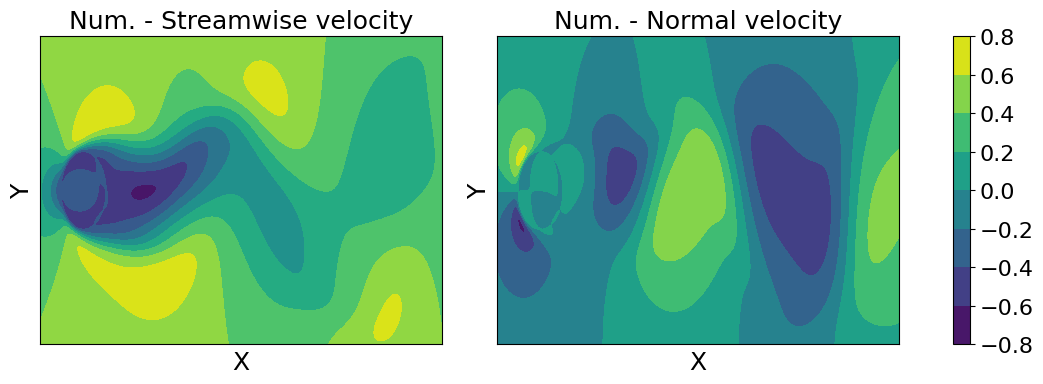

In [10]:
### Data is usually stored in .mat format
numericalTensor = list(loadmat('Tensor_cylinder_Re100.mat').values())[-1]

### Display both datasets
fig, ax = plt.subplots(1, 3, width_ratios = [25, 25, 1], figsize = (12, 4))

# Numerical dataset
ax[0].contourf(numericalTensor[0, ..., 0])
ax[0].set(title = 'Num. - Streamwise velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
im1 = ax[1].contourf(numericalTensor[1, ..., 0])
ax[1].set(title = 'Num. - Normal velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
plt.colorbar(im1, cax = ax[2])

### Creating a pipeline to preprocess the data
The goal is to forecast the next snapshots in high resolution.

In [15]:
def svdpreprocessing(Tensor, esvd, batch_size, seq_len, horizon, scaler_type, scaler_name):
    Tensor = np.reshape(Tensor, (-1, Tensor.shape[-1]))
    
    U, S, V = np.linalg.svd(Tensor, full_matrices = False)
    
    n_modes = 0
    norm = np.linalg.norm(S)
    
    for i in range(S.size):
        if np.linalg.norm(S[i:]) / norm <= esvd:
            pass
        else:
            n_modes += 1

    A_reconst = U[:, :n_modes] @ np.diag(S[:n_modes]) @ V[:n_modes, :]

    U = U[:, :n_modes]
    S = np.diag(S[:n_modes])
    V = V[:n_modes, :]

    print(f'''
Singular value decomposition summary
        - n_modes (retained modes): {n_modes}
        - U (POD modes): {U.shape}
        - S (singular values): {S.shape}
        - V (temporal coefficients): {V.shape}
        - TensorAprox (reconstructed tensor): {A_reconst.shape}
        ''')
    
    ### SVD modes evolution    
    fig, ax = plt.subplots(1, 1)
    for i in range(S.shape[0]):
        ax.plot(i + 1, S[i][i] / S[0][0], "ko") 
        
    ax.set_yscale('log')      # Logarithmic scale in y axis
    ax.set_xlabel('SVD modes')
    ax.set_ylabel('Singular values')
    ax.set_title('SVD modes vs. Singular values')
    plt.show()

    # Fourier 
    fig, ax = plt.subplots(2, 2, figsize = (10, 10))
    for i, axs in zip(range(4), ax.flatten()):
        axs.set(title = f'Mode: {i + 1}')
        temporal_coefficients = V[i, :].squeeze()
        fft_result = fft(temporal_coefficients)
        frequencies = np.fft.fftfreq(len(temporal_coefficients))
        axs.plot(frequencies[:len(frequencies)//2], np.abs(fft_result)[:len(frequencies)//2])
        if i > 1:
            axs.set_xlabel('Frequency')

        if i % 2 == 0:
            axs.set_ylabel('Amplitude')

    plt.show()

    if A_reconst.ndim == 5:
        nz = int(A_reconst.shape[-2] / 2)
        
        fig, ax = plt.subplots(1, 3, figsize = (10, 3))
        ax[0].contourf(A_reconst[0, ..., nz, 0], cmap = 'magma')
        ax[1].contourf(A_reconst[1, ..., nz,  0], cmap = 'magma')
        ax[2].contourf(A_reconst[2, ..., nz, 0], cmap = 'magma')
        ax[0].set(xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
        ax[1].set(xlabel = 'X', xticks = [], yticks = []) 
        ax[2].set(xlabel = 'X', xticks = [], yticks = []);

    elif A_reconst.ndim == 4:
        fig, ax = plt.subplots(1, 2, figsize = (10, 3))
        ax[0].contourf(A_reconst[0, ..., 0], cmap = 'magma')
        ax[1].contourf(A_reconst[1, ..., 0], cmap = 'magma')
        ax[0].set(xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
        ax[1].set(xlabel ='X', xticks = [], yticks = []);

    elif A_reconst.ndim == 3:
        fig, ax = plt.subplots(1, 1, figsize = (10, 3))
        ax.contourf(A_reconst[..., 0], cmap = 'magma')
        ax.set(xlabel = 'X', ylabel = 'Y');

    plt.suptitle('Tensor reconstructed using LC-HOSVD')
    plt.tight_layout()
    plt.show()
    
    split = 0.7

    print('Scaling the data...')        
    train, val, test, train_idx, val_idx, data_scaler = scaler(V, split, scaler_type, scaler_name)

    labels = ['Train', 'Validation', 'Test']
    fig, axs = plt.subplots(2, 2, figsize = (10, 4))
    for i, ax in zip(range(4), axs.flatten()):
        ax.set_title(f'Mode: {i + 1}')
        ax.plot(train[i, :], c = 'red')
        ax.plot(range(train_idx, train_idx + val_idx), val[i, :], c = 'blue')
        ax.plot(range(train_idx + val_idx, V.shape[-1]), test[i, :], c = 'green')
        if i <= 1:
            ax.set(xticks = [])

        if i % 2 != 0:
            ax.set(yticks = [])
        

    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.3)
    fig.legend(labels = labels, loc="lower center", ncol=3)
    
    plt.show()

    original_test = Tensor[..., train_idx + val_idx:]

    val = np.concatenate([train[:, -seq_len:], val], axis = 1)
    test = np.concatenate([val[:, -seq_len:], test], axis = 1)

    print(f'''
Split summary
    - Train samples: {train.shape}
    - Validation samples: {val.shape}
    - Test samples: {test.shape}
        ''')
    
    print('Creating data sequences...\n')
    train_seq, train_horizon = seqGenerator(train, seq_len, horizon)
    val_seq, val_horizon = seqGenerator(val, seq_len, horizon)
    test_seq, test_horizon = seqGenerator(test, seq_len, horizon)

    train_seq, val_seq, test_seq = train_seq.transpose(0, 2, 1), val_seq.transpose(0, 2, 1), test_seq.transpose(0, 2, 1)
    train_horizon, val_horizon, test_horizon = train_horizon.squeeze(), val_horizon.squeeze(), test_horizon.squeeze()
    
    print('Creating PyTorch datasets...\n')
    train_ds = TimeSeriesDataset(train_seq, train_horizon)
    val_ds = TimeSeriesDataset(val_seq, val_horizon)
    test_ds = TimeSeriesDataset(test_seq, test_horizon)

    print('Generating data loaders...\n')
    train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True, drop_last = True)
    val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
    test_loader = DataLoader(test_ds, batch_size = 1, shuffle = False)

    sample = next(iter(train_loader))
    print(f'Singular batch of the features (sequence): {sample[0].shape}')
    print(f'Singular batch of the target (horizon): {sample[1].shape}')

    print('\nData preprocessing complete!')

    return original_test, test, train_loader, val_loader, test_loader, n_modes, \
    train_ds, val_ds, U, S, train_seq, val_seq, test_seq, data_scaler

### Full data preprocessing and model training pipeline

In [16]:
def generator(Tensor, esvd, seq_len, horizon, batch_size, epochs, scaler_type, optimal, snapshots, model_save_path = 'SVD-DLinear.pth',
              scaler_name = 'SVD-DLinear_scaler'):

    print(colored('Step 1: Data preprocessing', 'red', attrs=["bold"]))
    test_data, test, train_loader, val_loader, test_loader, n_modes, train_ds, \
    val_ds, U, S, train_seq, val_seq, test_seq, data_scaler = svdpreprocessing(Tensor, esvd, batch_size, seq_len, horizon, scaler_type, scaler_name)

    print(colored('Step 2: Model definition', 'red', attrs=["bold"]))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    model = DLinear(sequence = seq_len, horizon = horizon, kernel_size = seq_len + 1 if 
                    (seq_len + 1) % 2 != 0 else seq_len, individual = True, input_size = n_modes)

    model.to(device)
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    learn_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total parameters: {total_params}')
    print(f'Learnable parameters: {learn_params}')

    print(colored('Step 3: Model training with optimal hyperparams.', 'red', attrs=["bold"]))
    all_losses = []
    loss_fn = nn.MSELoss()

    if not optimal:
        learning_rate = 0.000174
        batch_size = 4
        
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    else:
        train_loader, val_loader, learning_rate, weight_decay = hyperFinder(train_ds, val_ds, model, device)
        # Reinstanciate the model to avoid data leaking
        del model
        model = DLinear(sequence = seq_len, horizon = horizon, kernel_size = seq_len + 1 if 
                    (seq_len + 1) % 2 != 0 else seq_len, individual = True, input_size = n_modes)

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

    lr_patience = 10   
    es_patience = 15
    factor = 0.5

    lr_scheduler = LRScheduler(lr = learning_rate, optimizer = optimizer, patience = lr_patience, factor = factor)
    early_stopper = EarlyStopping(patience = es_patience, model_save_path = model_save_path)

    for epoch in range(epochs):
        train_loss = train_model(train_loader, model, loss_fn, optimizer, device)
        val_loss = val_model(val_loader, model, loss_fn, device)
        all_losses.append([train_loss, val_loss])

        print(f'\nEpoch [{epoch}/{epochs - 1}] - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}')

        early_stopper(epoch, model, val_loss)
        if early_stopper.early_stop:
            break

        lr_scheduler(val_loss)

    print('Model trained successfully!')
    print(f'Best model has been saved as: {model_save_path}')

    print(colored('Step 4: Load the best epoch and plot the losses', 'red', attrs=["bold"]))
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    print('Model loaded')

    fig, ax = plt.subplots(1, 1, figsize = (6, 6))
    ax.plot(np.array(all_losses)[:, 0].reshape(-1, 1), c = 'k', label = 'Train loss')
    ax.plot(np.array(all_losses)[:, 1].reshape(-1, 1), c = 'r', label = 'Validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE')
    ax.set_title('Training vs. Validation loss')
    ax.legend(loc = 'best')
    plt.show()

    print(colored('Step 5: Validate the model on test data' 'red', attrs=["bold"]))
    preds = []

    X = test_seq[0][np.newaxis, :, :].astype(float) 

    print(f'Input tensor (first sequence from the test data): {X.shape}')

    seq = torch.tensor(X.copy()).float().to(device) 

    num_snaps = test_data.shape[-1]

    with torch.no_grad():
        for i in range(num_snaps):
            y = model(seq)
            pred = y.detach().cpu().numpy()
            preds.append(data_scaler.inverse_transform(pred )) # de-scale data
            seq = torch.cat((seq, y[None, :, :]), axis = 1)
            seq = seq[:, -seq_len:, :]

    pred = U @ S @ np.array(preds).squeeze().T

    shape_ = test_data.shape

    pred = np.reshape(pred, shape_)

    RRMSE = np.linalg.norm(np.reshape(test_data - np.array(pred), newshape=(np.size(test_data), 1)), ord = 2) / np.linalg.norm(np.reshape(test_data, newshape = (np.size(test_data), 1))) * 100

    print(f'''
    Error summary
    RRMSE [%]: {RRMSE:.3f}
    MAE: {compute_MAE(test[:, seq_len:].T, np.array(preds).squeeze()):.3f}
    MSE: {compute_MSE(test[:, seq_len:].T, np.array(preds).squeeze()):.3f}
    ''')

    fig, ax = plt.subplots(2, 2, figsize = (10, 10))
    labels = ['Ground truth', 'Forecast']
    for i, axs in zip(range(4), ax.flatten()):
        test_modes = data_scaler.inverse_transform(test.T)[seq_len:, i].squeeze() 
        axs.plot(test_modes, c = 'k')
        axs.plot(np.array(preds)[..., i].squeeze(), alpha = 0.7, c = 'red')
        axs.set(title = f'Mode: {i + 1}')
        if i <= 1:
            axs.set(xticks = [])

    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1075)
    fig.legend(labels=labels, loc="lower center", ncol=2)

    print(colored('Step 6: Forecast new snapshots', 'red', attrs=["bold"]))

    X = test_seq[-1][np.newaxis, :, :].astype(float) 

    print(f'Input tensor (last sequence from the test data): {X.shape}')

    seq = torch.tensor(X.copy()).float().to(device) 

    preds = [] 

    num_snaps = snapshots

    with torch.no_grad():
        for i in range(num_snaps):
            y = model(seq)
            pred = y.detach().cpu().numpy()
            preds.append(data_scaler.inverse_transform(pred) ) # de-scale data
            seq = torch.cat((seq, y[None, :, :]), axis = 1)
            seq = seq[:, -seq_len:, :]
    
    forecast_sV = np.array(preds)

    print(f'Prediction shape [V.T]: {forecast_sV.squeeze().shape}')

    indxs = np.arange(len(np.array(test.T)), len(np.array(preds)) + len(np.array(test.T)))
    test_indxs = np.arange(len(np.array(test.T)))

    labels = ['Test data', 'Forecast']

    fig, ax = plt.subplots(2, 2, figsize = (10, 10))
    for i, axs in zip(range(4), ax.flatten()):
        axs.plot(data_scaler.inverse_transform(test.T)[:, i].squeeze() , c = 'k')
        axs.plot(indxs, np.array(preds)[..., i].squeeze(), c = 'red', alpha = 0.7)
        axs.set(title = f'Mode: {i + 1}')
        if i <= 1:
            axs.set(xticks = [])
    
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1075)
    fig.legend(labels=labels, loc="lower center", ncol=2)
    
    plt.show()

    print(colored('Step 7: Reconstruct the new snapshots', 'red', attrs=["bold"]))
    forecast = U @ S @ (np.concatenate([data_scaler.inverse_transform(test.transpose(1, 0)), forecast_sV.squeeze()], axis = 0).T )

    nv, ny, nx, _ = Tensor.shape
    forecast = forecast.reshape((nv, ny, nx, -1))
    nz = None
        
    print(f'''
    Number of components: {nv}
    Number of points in x: {nx}
    Number of points in y: {ny}
    Number of points in z: {nz}
    ''')

    print(f'Reconstructed test + forecast data: {forecast.shape}')

    return test_data, forecast, test

### Training and testing the model

Step 1: Data preprocessing

Singular value decomposition summary
        - n_modes (retained modes): 8
        - U (POD modes): (178702, 8)
        - S (singular values): (8, 8)
        - V (temporal coefficients): (8, 151)
        - TensorAprox (reconstructed tensor): (178702, 151)
        


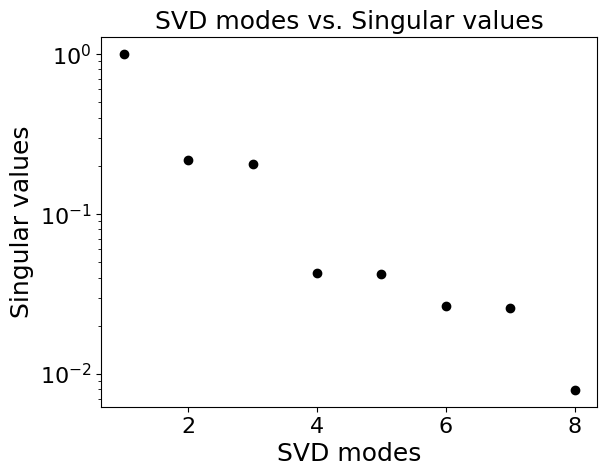

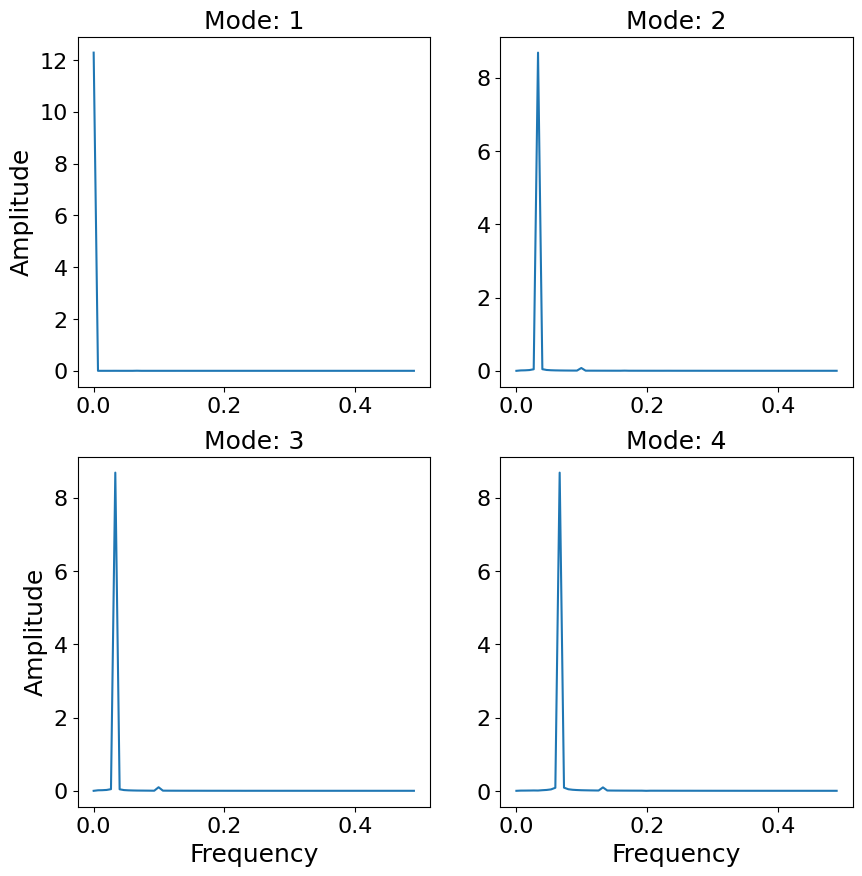

<Figure size 640x480 with 0 Axes>

Scaling the data...


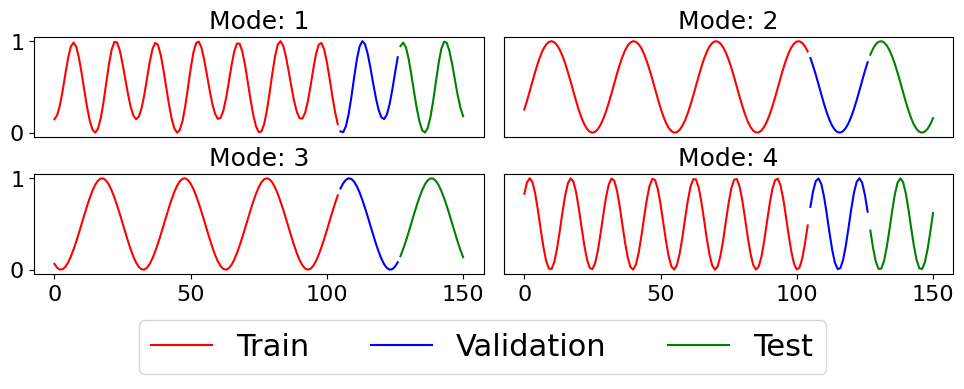

[I 2025-03-27 19:42:38,079] A new study created in memory with name: no-name-053d3d1b-00d4-4511-ae91-782375a3ee55



Split summary
    - Train samples: (8, 105)
    - Validation samples: (8, 52)
    - Test samples: (8, 54)
        
Creating data sequences...

Creating PyTorch datasets...

Generating data loaders...

Singular batch of the features (sequence): torch.Size([4, 30, 8])
Singular batch of the target (horizon): torch.Size([4, 8])

Data preprocessing complete!
Step 2: Model definition
DLinear(
  (decomposition): series_descomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(31,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): ModuleList(
    (0-7): 8 x Linear(in_features=30, out_features=1, bias=True)
  )
  (Linear_Trend): ModuleList(
    (0-7): 8 x Linear(in_features=30, out_features=1, bias=True)
  )
)
Total parameters: 496
Learnable parameters: 496
Step 3: Model training with optimal hyperparams.


[I 2025-03-27 19:42:39,018] Trial 0 finished with value: 11.57772159576416 and parameters: {'weight_decay': 2.025470002201028e-07, 'lr': 0.00011215268061748795, 'batch_size': 32}. Best is trial 0 with value: 11.57772159576416.
[I 2025-03-27 19:42:47,064] Trial 1 finished with value: 0.011859394609928131 and parameters: {'weight_decay': 2.976991844930164e-09, 'lr': 0.005470167331566269, 'batch_size': 4}. Best is trial 1 with value: 0.011859394609928131.
[I 2025-03-27 19:42:56,302] Trial 2 finished with value: 0.0005252122646197677 and parameters: {'weight_decay': 1.8556582778620975e-14, 'lr': 0.0001579323157799663, 'batch_size': 4}. Best is trial 2 with value: 0.0005252122646197677.
[I 2025-03-27 19:43:05,398] Trial 3 finished with value: 0.0009743369300849736 and parameters: {'weight_decay': 9.750574941132226e-05, 'lr': 0.0006639814440314765, 'batch_size': 4}. Best is trial 2 with value: 0.0005252122646197677.
[I 2025-03-27 19:43:06,930] Trial 4 finished with value: 0.00039566610939800

Study statistics: 
     Number of finished trials:  50
     Number of pruned trials:  19
     Number of completed trials:  31
Best trial: 
     Value:  0.00015800888650119305
     Params: 
    weight_decay: 5.004160567677578e-14
    lr: 0.000157613640485989
    batch_size: 32

Epoch [0/999] - Train Loss: 0.372704 - Val Loss: 0.358913

Epoch [1/999] - Train Loss: 0.370127 - Val Loss: 0.352094

Epoch [2/999] - Train Loss: 0.370038 - Val Loss: 0.345299

Epoch [3/999] - Train Loss: 0.353556 - Val Loss: 0.338589

Epoch [4/999] - Train Loss: 0.338913 - Val Loss: 0.331944

Epoch [5/999] - Train Loss: 0.340265 - Val Loss: 0.325386

Epoch [6/999] - Train Loss: 0.332330 - Val Loss: 0.318910

Epoch [7/999] - Train Loss: 0.337667 - Val Loss: 0.312513

Epoch [8/999] - Train Loss: 0.326167 - Val Loss: 0.306212

Epoch [9/999] - Train Loss: 0.307333 - Val Loss: 0.299998

Epoch [10/999] - Train Loss: 0.294543 - Val Loss: 0.293930

Epoch [11/999] - Train Loss: 0.295915 - Val Loss: 0.287960

Epoch [12/99

C:\Users\ahetherington\AppData\Local\Temp\Mxt236\ahetherington_agastya\var\log\xwin\ipykernel_24572\2616788460.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.loa

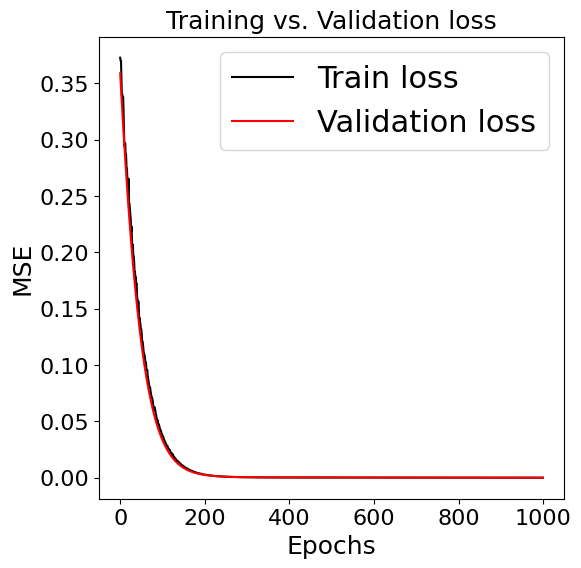

Step 5: Validate the model on test datared
Input tensor (first sequence from the test data): (1, 30, 8)

    Error summary
    RRMSE [%]: 0.979
    MAE: 0.511
    MSE: 0.342
    
Step 6: Forecast new snapshots
Input tensor (last sequence from the test data): (1, 30, 8)
Prediction shape [V.T]: (500, 8)


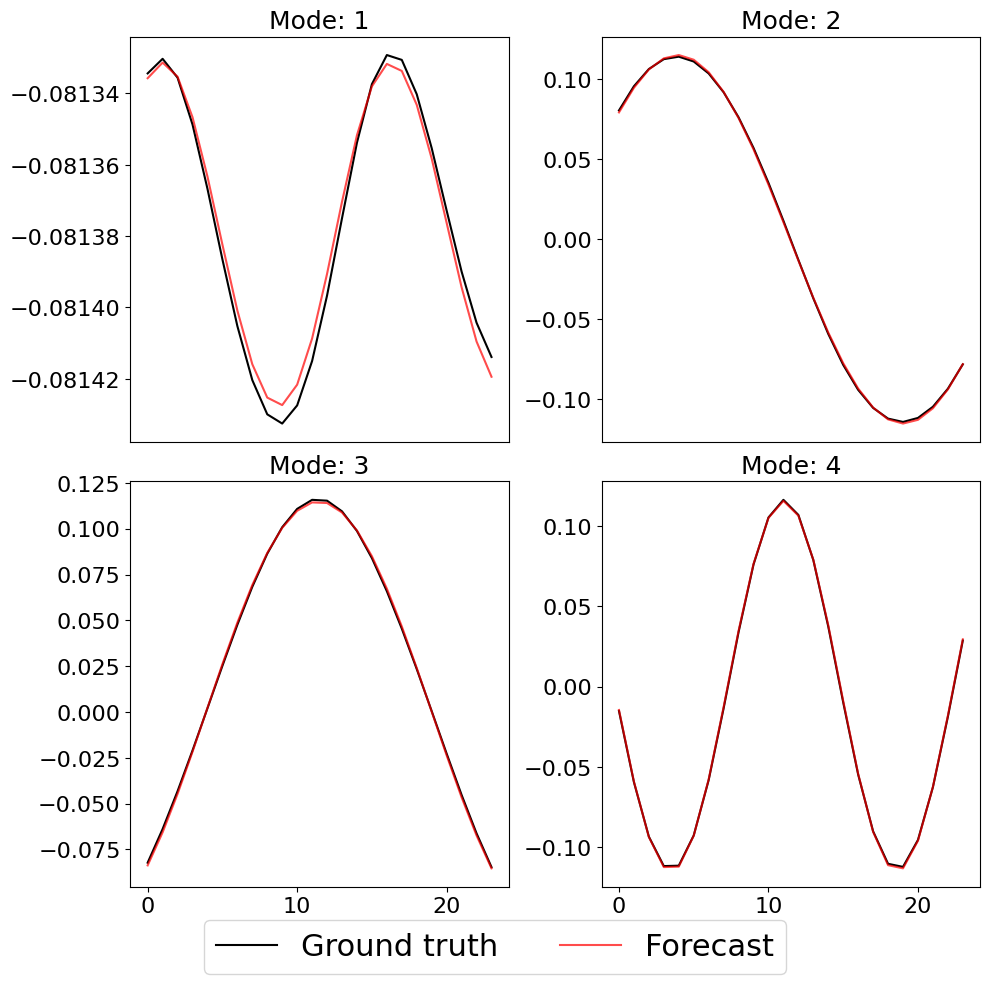

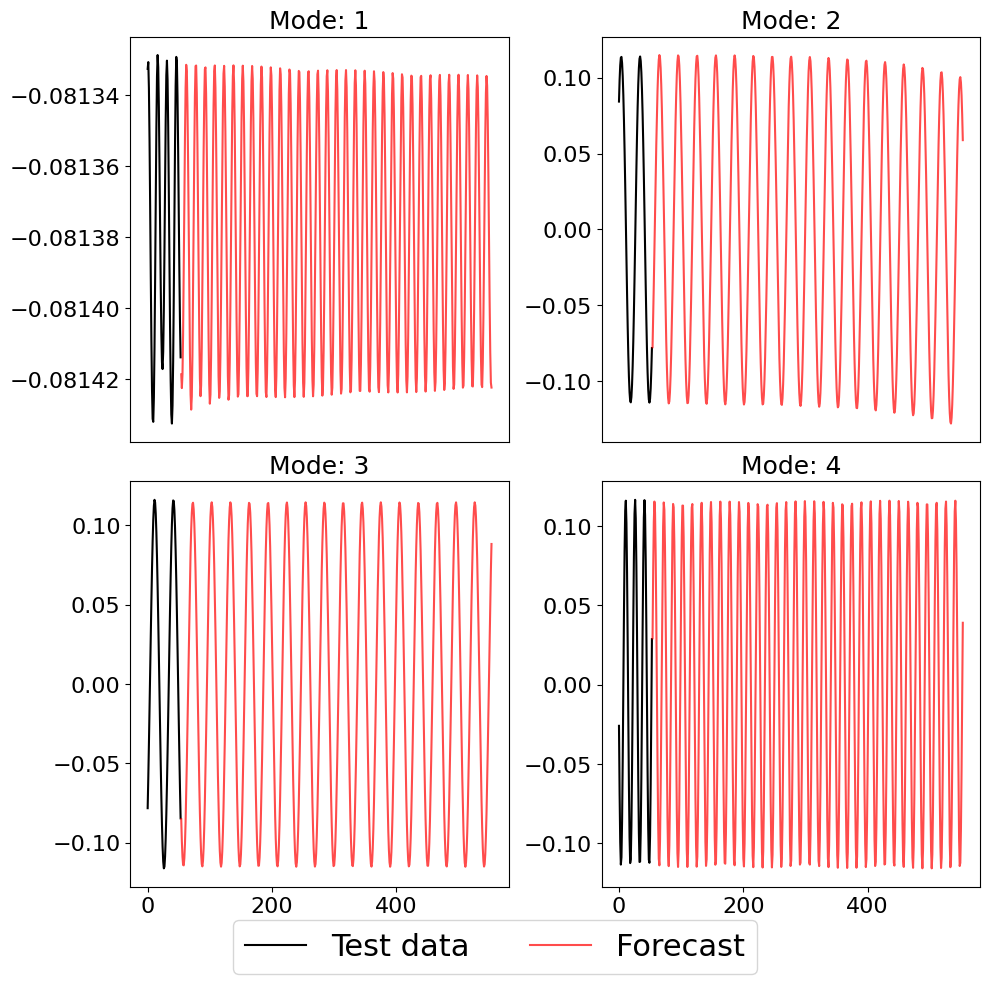

Step 7: Reconstruct the new snapshots

    Number of components: 2
    Number of points in x: 449
    Number of points in y: 199
    Number of points in z: None
    
Reconstructed test + forecast data: (2, 199, 449, 554)


In [78]:
# Select the parameters
esvd = 1e-2
seq_len = 30
horizon = 1
scaler_type = 'minmax'
batch_size = 4
snapshots = 500
optimal = True
epochs = 1000

# Preprocess the data and train the model
test_data, forecast, test = generator(numericalTensor, esvd, seq_len, horizon, batch_size, epochs, scaler_type, optimal, snapshots)

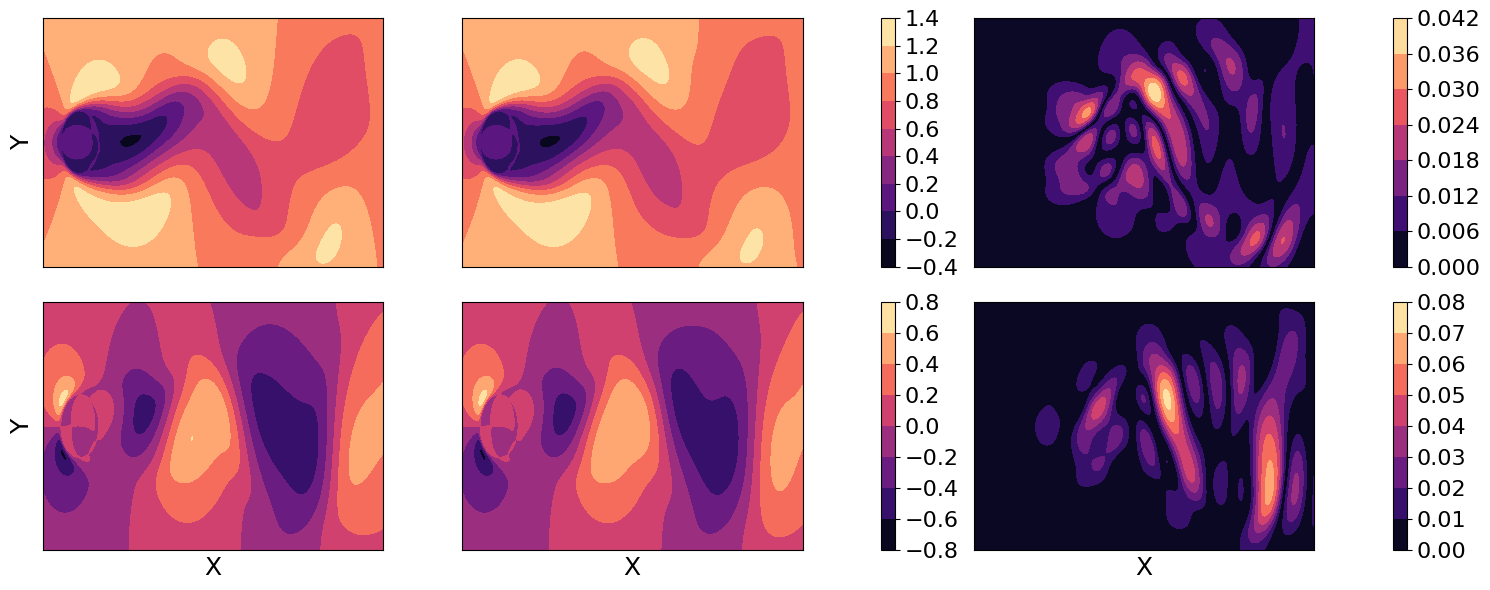

In [80]:
test_forecast = forecast.copy()[..., :test_data.shape[-1]]
test_data = test_data.reshape(test_forecast.shape)

erroru = np.abs(test_data[0, ...] - test_forecast[0, ...])
errorv = np.abs(test_data[1, ...] - test_forecast[1, ...])

su = sv = test_data.shape[-1] - 1

fig, ax = plt.subplots(test_forecast.shape[0], 5, figsize=(15, 6), width_ratios=[25, 25, 1, 25, 1])
for axs in ax.flatten():
    axs.set(xticks=[], yticks=[])

ax[0, 0].set_ylabel('Y')
ax[0, 0].yaxis.set_label_coords(-0.025, .5)
ax[1, 0].set_ylabel('Y')
ax[1, 0].yaxis.set_label_coords(-0.025, .5)

ax[1, 0].set_xlabel('X')
ax[1, 1].set_xlabel('X')
ax[1, 3].set_xlabel('X')

ax[0, 0].contourf(test_data[0, ..., su], cmap='magma')
im1 = ax[0, 1].contourf(test_forecast[0, ..., su], cmap='magma')
im2 = ax[0, 3].contourf(erroru[..., su], cmap='magma')

ax[1, 0].contourf(test_data[1, ..., sv], cmap='magma')
im3 = ax[1, 1].contourf(test_forecast[1, ..., sv], cmap='magma')
im4 = ax[1, 3].contourf(errorv[..., sv], cmap='magma')

plt.colorbar(im1, cax=ax[0, 2])
plt.colorbar(im3, cax=ax[1, 2])
plt.colorbar(im2, cax=ax[0, 4])
plt.colorbar(im4, cax=ax[1, 4])

plt.tight_layout()
plt.show()

### Use a pretrained model

In [81]:
def test_forecast(Tensor, esvd, seq_len, horizon, model_save_path, scaler_name, num_snaps):    
    Tensor_ = np.reshape(Tensor, (-1, Tensor.shape[-1]))
    
    U, S, V = np.linalg.svd(Tensor_, full_matrices = False)
    
    n_modes = 0
    norm = np.linalg.norm(S)
    
    for i in range(S.size):
        if np.linalg.norm(S[i:]) / norm <= esvd:
            pass
        else:
            n_modes += 1

    U = U[:, :n_modes]
    S = np.diag(S[:n_modes])
    V = V[:n_modes, :]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = DLinear(sequence = seq_len, horizon = horizon, kernel_size = seq_len + 1 if 
                (seq_len + 1) % 2 != 0 else seq_len, individual = True, input_size = n_modes)
        
    model.to(device)
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    learn_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total parameters: {total_params}')
    print(f'Learnable parameters: {learn_params}')

    model.load_state_dict(torch.load(model_save_path))
    model.eval()

    with open(f"{scaler_name}.pkl", "rb") as f:
        data_scaler = pickle.load(f)

    test = V[:, -seq_len:]

    test_seq = data_scaler.transform(test.transpose(1, 0))

    X = test_seq[np.newaxis, :, :].astype(float) 

    seq = torch.tensor(X.copy()).float().to(device) 

    preds = [] 

    with torch.no_grad():
        for i in range(num_snaps):
            y = model(seq)
            pred = y.detach().cpu().numpy()
            preds.append(data_scaler.inverse_transform(pred) ) # de-scale data
            seq = torch.cat((seq, y[None, :, :]), axis = 1)
            seq = seq[:, -seq_len:, :]
    
    forecast_sV = np.array(preds)

    print(f'Prediction shape [V.T]: {forecast_sV.squeeze().shape}')

    indxs = np.arange(len(np.array(V.T)), len(np.array(preds)) + len(np.array(V.T)))

    labels = ['Test data', 'Forecast']

    fig, ax = plt.subplots(2, 2, figsize = (10, 10))
    for i, axs in zip(range(4), ax.flatten()):
        axs.plot(V.T[:, i].squeeze() , c = 'k')
        axs.plot(indxs, np.array(preds)[..., i].squeeze(), c = 'red', alpha = 0.7)
        axs.set(title = f'Mode: {i + 1}')
        if i <= 1:
            axs.set(xticks = [])
    
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1075)
    fig.legend(labels=labels, loc="lower center", ncol=2)
    
    plt.show()

    forecast = U @ S @ np.concatenate([V, forecast_sV.squeeze().T], axis = 1) 

    nv, ny, nx, _ = Tensor.shape
    forecast = forecast.reshape((nv, ny, nx, -1))
    nz = None
        
    print(f'''
    Number of components: {nv}
    Number of points in x: {nx}
    Number of points in y: {ny}
    Number of points in z: {nz}
    ''')

    print(f'Reconstructed test + forecast data: {forecast.shape}')

    return forecast

DLinear(
  (decomposition): series_descomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(31,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): ModuleList(
    (0-7): 8 x Linear(in_features=30, out_features=1, bias=True)
  )
  (Linear_Trend): ModuleList(
    (0-7): 8 x Linear(in_features=30, out_features=1, bias=True)
  )
)
Total parameters: 496
Learnable parameters: 496


C:\Users\ahetherington\AppData\Local\Temp\Mxt236\ahetherington_agastya\var\log\xwin\ipykernel_24572\2818814744.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.loa

Prediction shape [V.T]: (250, 8)


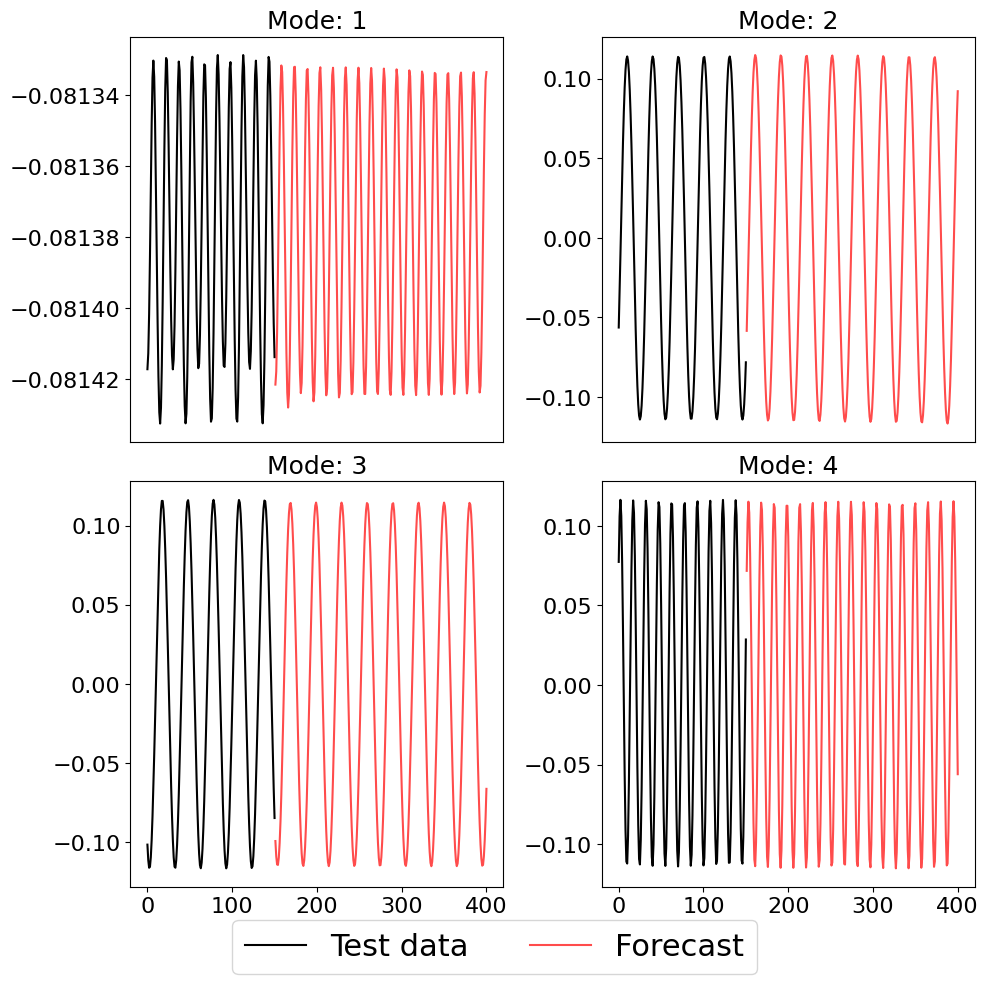


    Number of components: 2
    Number of points in x: 449
    Number of points in y: 199
    Number of points in z: None
    
Reconstructed test + forecast data: (2, 199, 449, 401)


In [84]:
Tensor = list(loadmat('Tensor_cylinder_Re100.mat').values())[-1]
esvd = 1e-2
seq_len = 30
horizon = 1
num_snaps = 250
model_save_path = 'SVD-DLinear.pth'
scaler_name = 'SVD-DLinear_scaler'

new_tensor = test_forecast(Tensor, esvd, seq_len, horizon, model_save_path, scaler_name, num_snaps)

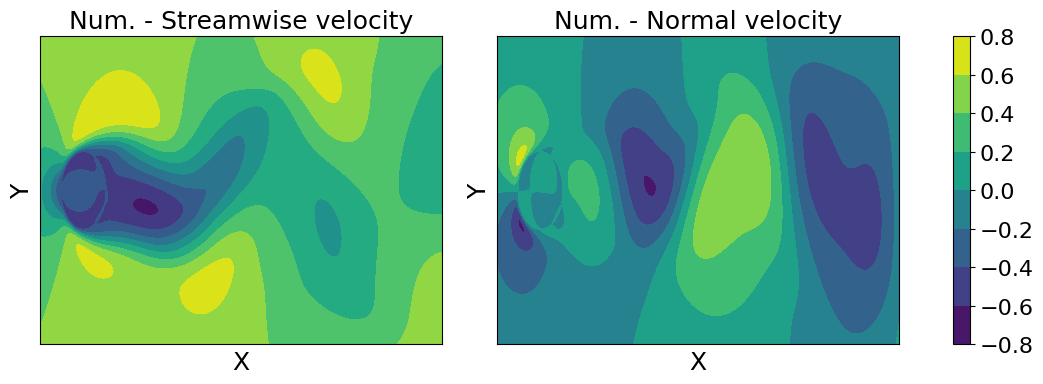

In [85]:
### Display the last forecast snapshot
fig, ax = plt.subplots(1, 3, width_ratios = [25, 25, 1], figsize = (12, 4))

ax[0].contourf(new_tensor[0, ..., -1])
ax[0].set(title = 'Num. - Streamwise velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
im1 = ax[1].contourf(new_tensor[1, ..., -1])
ax[1].set(title = 'Num. - Normal velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
plt.colorbar(im1, cax = ax[2]);